In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from tqdm.notebook import tqdm
from pathlib import Path

In [2]:
pd.set_option("display.max_rows", 500)

# Import datasets

In [3]:
%%time

datasets = {
    'AmpC': r'/storage/margaritakovaleva/2021-06-15_big_datasets/AmpC_screen_table_1M/result_single_Morgan_size=2048_radius=2.csv',
    'D4': r'/storage/margaritakovaleva/2021-06-15_big_datasets/D4_screen_table_1M/result_single_Morgan_size=2048_radius=2.csv',
    'CB2': '/storage/margaritakovaleva/2022-07-22_tables/5zty/result_single_Morgan_size=2048_radius=2.csv',
    'AA2AR': '/storage/margaritakovaleva/2022-07-22_tables/4eiy/result_single_Morgan_size=2048_radius=2.csv'
}
dataset_size = {'AmpC': 96214206, 'D4': 138312677,
                'AA2AR': int(1e6), 'CB2': int(1e6)}

dfs = []
for name, path in tqdm(datasets.items()):
    df = pd.read_csv(path)
    df['proj'] = name
    df['N_ligands'] = dataset_size.get(name)
    dfs.append(df)

raw_data = pd.concat(dfs)


  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 27.8 ms, sys: 9.79 ms, total: 37.6 ms
Wall time: 33.4 ms


In [4]:
raw_data.columns

Index(['Unnamed: 0', 'model', 'type', 'top_threshold', 'train_size',
       'accuracy_score', 'precision_score', 'recall_score', 'TP+FP', 'docked',
       'time_sec', 'fingerprints', 'proj', 'N_ligands'],
      dtype='object')

# Convert types and select necessary subframe

In [5]:
def threshold_to_int(df: pd.DataFrame) -> pd.DataFrame:
    def threshold2int(s):
        return float(s.replace("%", " ").split()[1])

    df["top_threshold"] = df.apply({"top_threshold": threshold2int})
    return df


In [6]:
df = (
    raw_data.drop("Unnamed: 0", axis=1)
    .pipe(threshold_to_int)
    .dropna(axis=1)
    .rename({"type": "model_type"}, axis=1)
    .query('model_type == "regressor"')
    .query("top_threshold == 1")
    .query("train_size != 20_000")
    .query("train_size != 10_000")
    .reset_index()
    .drop(
        [
            "model_type",
            "top_threshold",
            "accuracy_score",
            "precision_score",
            "TP+FP",
            "fingerprints",
        ],
        axis=1,
    )
)

In [7]:
df.sample(10)

,index,model,train_size,recall_score,docked,time_sec,proj,N_ligands
710,1530,KNeighborsRegressor,160000,0.0900,160400,19658,CB2,1000000
592,1087,Ridge,160000,0.0475,160400,63,CB2,1000000
385,309,WeightedLinearRegressionScale20,40000,0.0100,40100,22,CB2,1000000
167,476,SVR,160000,0.1525,160400,11019,D4,138312677
789,1061,LinearRegression,160000,0.1525,160400,191,AA2AR,1000000
722,1557,LinearSVR,160000,0.1500,160400,16,CB2,1000000
692,1461,LinearRegression,80000,0.0900,80200,21,CB2,1000000
86,802,LinearRegression,160000,0.3725,160400,29,AmpC,96214206
240,759,SVR,80000,0.1350,80200,25732,D4,138312677
732,824,KNeighborsRegressor,8000,0.0500,8020,86,AA2AR,1000000


# Find which values are missing

In [8]:
# should be following:
# - for each model
# - and train size
# - and proj
# I should have exactly 5 values in the subtable


In [9]:
agg = df.groupby(["train_size", "proj", "model"], as_index=False).agg("count")
agg.query("index != 5")


,train_size,proj,model,index,recall_score,docked,time_sec,N_ligands
108,80000,CB2,DockingAsPredictor,1,1,1,1,1
128,80000,D4,LinearSVR,4,4,4,4,4
144,160000,AA2AR,SVR,3,3,3,3,3
152,160000,CB2,DockingAsPredictor,1,1,1,1,1
160,160000,CB2,RandomUniformRegressor,1,1,1,1,1
179,320000,AA2AR,KNeighborsRegressorWithOneNeighbor,3,3,3,3,3
183,320000,AA2AR,RandomForestRegressor,4,4,4,4,4
187,320000,AA2AR,SVR,3,3,3,3,3
192,320000,AmpC,RandomForestRegressor,4,4,4,4,4
194,320000,CB2,DockingAsPredictor,2,2,2,2,2


Let's for each dataset find out which regressors we can use


In [10]:
for proj in df.proj.unique():
    print(f"{proj=}")
    agg = (
        df.query(f'proj=="{proj}"')
        .groupby(["train_size", "proj", "model"], as_index=False)
        .agg("count")
    )
    print(*["\t" + s for s in agg.query("index == 5").model.unique()], sep="\n")

proj='AmpC'
	DecisionTreeRegressor
	KNeighborsRegressor
	LassoCV
	LinearRegression
	RandomForestRegressor
	RidgeCV
proj='D4'
	DecisionTreeRegressor
	KNeighborsRegressor
	LassoCV
	LinearRegression
	LinearSVR
	RandomForestRegressor
	RidgeCV
	SVR
proj='CB2'
	DecisionTreeRegressor
	DockingAsPredictor
	KNeighborsRegressor
	KNeighborsRegressorWithOneNeighborJaccard
	Lasso
	LassoCV
	LinearRegression
	LinearSVR
	RandomForestRegressor
	RandomGaussianRegressor
	RandomUniformRegressor
	Ridge
	RidgeCV
	WeightedLinearRegressionScale10
	WeightedLinearRegressionScale100
	WeightedLinearRegressionScale20
	WeightedLinearRegressionScale50
proj='AA2AR'
	DecisionTreeRegressor
	DockingAsPredictor
	DummyRegressor
	KNeighborsRegressor
	KNeighborsRegressorWithOneNeighbor
	LassoCV
	LinearRegression
	LinearSVR
	RandomForestRegressor
	RandomGaussianRegressor
	RandomUniformRegressor
	Ridge
	SVR


Now, let's understand how can we incorporate this info into a figure with single-shot performance, and also into a execution time figure.
I think the best way to do that would be:
 - manually create list of not interesting regressors (and exclude them)
 - create new `df_p` that would contain only the data for plotting
 - plot it)))

# Manually filter regressors we're not gonna use

In [11]:
# print all good regressors

available_regressors = []

for proj in df.proj.unique():
    agg = (
        df.query(f'proj=="{proj}"')
        .groupby(["train_size", "proj", "model"], as_index=False)
        .agg("count")
    )
    available_regressors.extend(agg.query("index == 5").model.unique())

available_regressors = list(set(available_regressors))
print(*sorted(available_regressors), sep="\n")

DecisionTreeRegressor
DockingAsPredictor
DummyRegressor
KNeighborsRegressor
KNeighborsRegressorWithOneNeighbor
KNeighborsRegressorWithOneNeighborJaccard
Lasso
LassoCV
LinearRegression
LinearSVR
RandomForestRegressor
RandomGaussianRegressor
RandomUniformRegressor
Ridge
RidgeCV
SVR
WeightedLinearRegressionScale10
WeightedLinearRegressionScale100
WeightedLinearRegressionScale20
WeightedLinearRegressionScale50


In [12]:
interesting_regressors = """
RandomGaussianRegressor
#DockingAsPredictor
LinearRegression
Lasso
LassoCV
Ridge
RidgeCV
SVR
LinearSVR
KNeighborsRegressor
KNeighborsRegressorWithOneNeighbor
KNeighborsRegressorWithOneNeighborJaccard
DecisionTreeRegressor
RandomForestRegressor
#RandomUniformRegressor
#DummyRegressor
#WeightedLinearRegressionScale10
#WeightedLinearRegressionScale100
#WeightedLinearRegressionScale20
#WeightedLinearRegressionScale50
""".split()
interesting_regressors = [s for s in interesting_regressors if not s.startswith("#")]

In [13]:
## this version will give me only those regressors that are good within one fold
# available_regressors = []
# 
# cols = ["train_size", "proj", "model"]
# agg = df.groupby(cols).agg({"index": "count"})
# agg.columns = ["n_folds"]

## this is good for getting models that don't have missing values for all folds
cols = ["proj", "model"]
agg = df.groupby(cols).agg({"index": "count"})
agg.columns = ["n_folds"]

In [14]:
row_order = ["AA2AR", "CB2", "AmpC", "D4"]
df_p = (
    df.query("model in @interesting_regressors")
    .merge(agg, left_on=cols, right_index=True, suffixes=("", "_agg"))
    .query("n_folds == 25")
    .sort_values("model", key=lambda x: x.map(interesting_regressors.index))
    .sort_values("proj", key=lambda x: x.map(row_order.index))
    .reset_index()
    .drop(["level_0", "index", "n_folds"], axis=1)
    .assign(row_order=lambda x: x.index)
)


## Print regressors for each project

In [15]:
for proj in df_p.proj.unique():
    print(f"{proj=}")
    agg = (
        df_p.query(f'proj=="{proj}"')
        .groupby(["proj", "model"], as_index=False)
        .agg("count")
    )
    print(*["\t" + s for s in agg.model.unique()], sep="\n")

proj='AA2AR'
	DecisionTreeRegressor
	KNeighborsRegressor
	LassoCV
	LinearRegression
	LinearSVR
	RandomGaussianRegressor
	Ridge
proj='CB2'
	Lasso
	LassoCV
	LinearRegression
	LinearSVR
	RandomForestRegressor
	RandomGaussianRegressor
	Ridge
	RidgeCV
proj='AmpC'
	DecisionTreeRegressor
	KNeighborsRegressor
	LassoCV
	LinearRegression
	RidgeCV
proj='D4'
	DecisionTreeRegressor
	KNeighborsRegressor
	LassoCV
	LinearRegression
	RandomForestRegressor
	RidgeCV


# Do the actual plotting

In [16]:
import matplotlib

font = {'family' : 'normal',
        'size'   : 24}

matplotlib.rc('font', **font)

In [17]:
def ordered_stripplot(*args, **kwargs):
    # modified from https://stackoverflow.com/questions/46465368/order-of-categoricals-in-seaborn-pairgrid
    # and https://stackoverflow.com/questions/29968097/seaborn-facetgrid-user-defined-plot-function
    order = kwargs.pop("order")
    data = kwargs['data']
    proj = data.proj.unique()[0]
    order = order[proj]
    sns.stripplot(x=kwargs.pop('x'), y=kwargs.pop('y'), order=order, **kwargs)

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
/tmp/ipykernel_73633/502661270.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=kwargs.pop('x'), y=kwargs.pop('y'), order=order, **kwargs)
/tmp/ipykernel_73633/502661270.

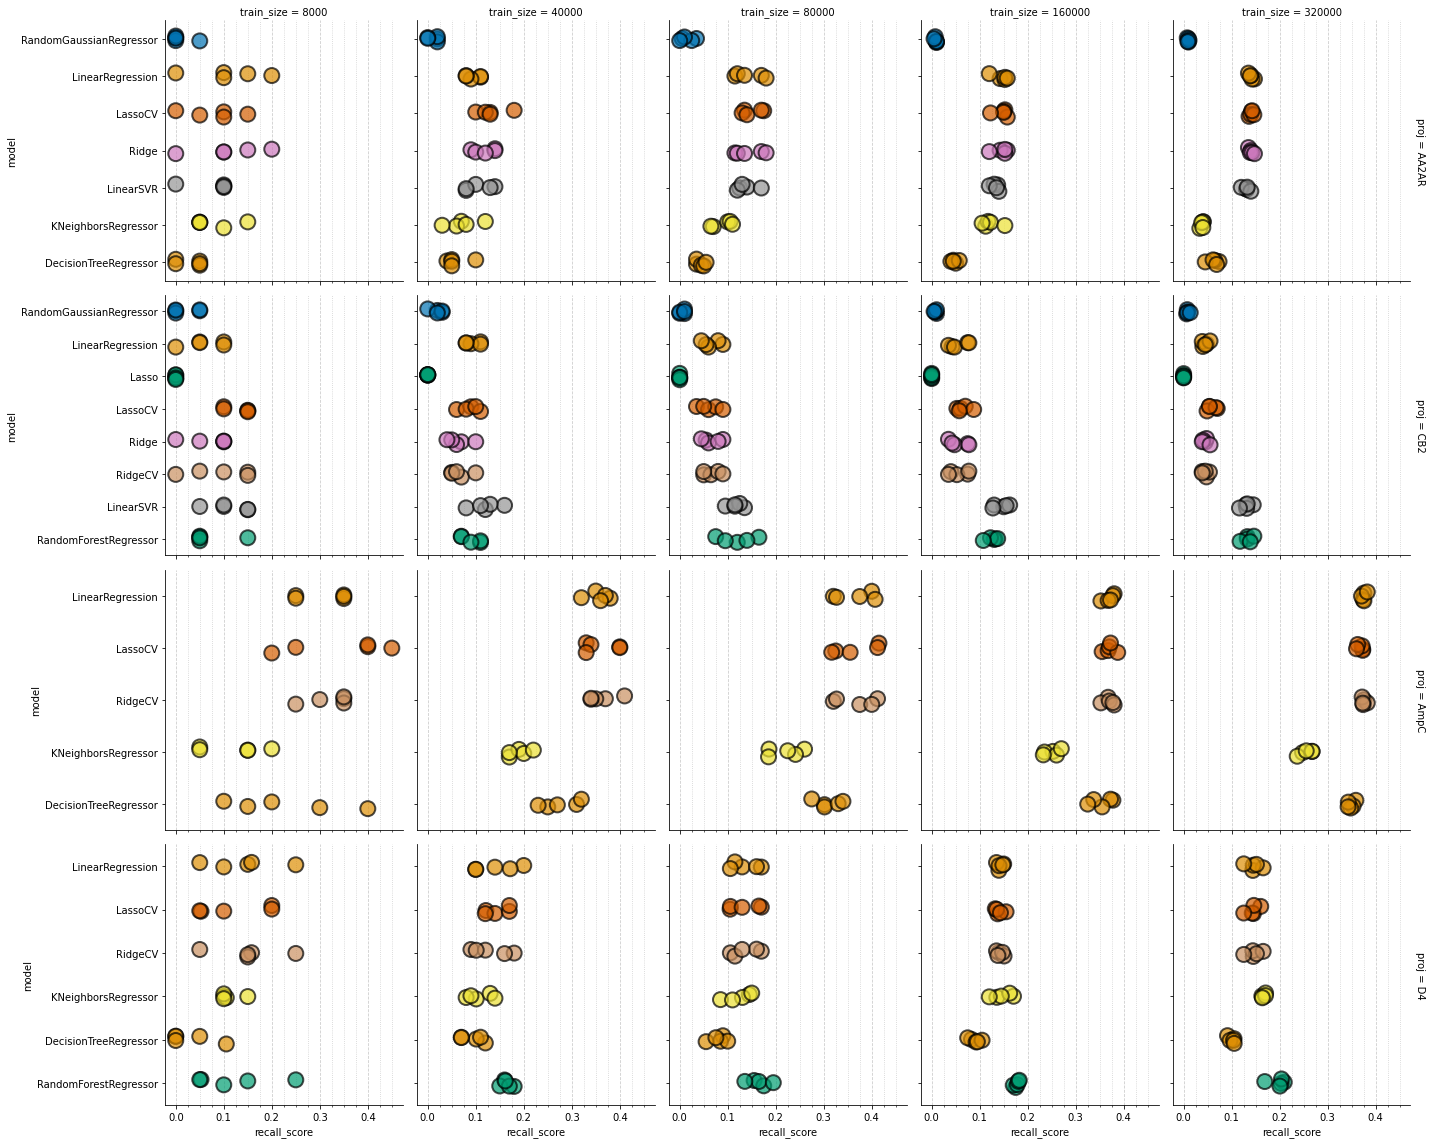

In [18]:
grid = sns.FacetGrid(
    data=df_p,
    col="train_size",
    row="proj",
    margin_titles=True,
    sharex=True,
    sharey="row",
    height=4,
    aspect=1.0,
    # row_order=row_order,
)

for ax in grid.axes.flat:
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(1))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))
    ax.grid(which="major", color="#CCCCCC", linestyle="--")
    ax.grid(which="minor", color="#CCCCCC", linestyle=":")

# ----------------------

colors = sns.color_palette("colorblind", n_colors=len(interesting_regressors))
palette = {tag: color for tag, color in zip(interesting_regressors, colors)}
custom_order = {
    k: [model for model in interesting_regressors
        if
        model in df_p.query(f'proj=="{k}"').model.unique()]
    for k in row_order
}

kwa = {
    "x": "recall_score",
    "y": "model",
    "edgecolor": "k",
    "linewidth": 2,
    "palette": palette,
    "s": 15,
    "alpha": 0.7,
    "order": custom_order,
}


grid.map_dataframe(
    ordered_stripplot,
    **kwa,
)
# grid.map_dataframe(
#    sns.stripplot,
#    **kwa,
# )

fout = "../figures/Figure_3_single-shot-performance.png"
if not Path(fout).exists():
    print(f"Saved figure to {fout=}")
    plt.savefig(fout)


Ok, this version of the plot doesn't have fancy regressors such as KNN with 1 neighbour, etc.

So, let's try to exclude one of the train sizes to make more different models available.

# Find which train sizes we can exclude to make more regressors available

In [19]:
# print all good regressors

available_regressors = []

for proj in df.proj.unique():
    agg = (
        df.query(f'proj=="{proj}"')
        .groupby(["train_size", "proj", "model"], as_index=False)
        .agg("count")
    )
    available_regressors.extend(agg.query("index == 5").model.unique())

available_regressors = list(set(available_regressors))
print(*sorted(available_regressors), sep="\n")

DecisionTreeRegressor
DockingAsPredictor
DummyRegressor
KNeighborsRegressor
KNeighborsRegressorWithOneNeighbor
KNeighborsRegressorWithOneNeighborJaccard
Lasso
LassoCV
LinearRegression
LinearSVR
RandomForestRegressor
RandomGaussianRegressor
RandomUniformRegressor
Ridge
RidgeCV
SVR
WeightedLinearRegressionScale10
WeightedLinearRegressionScale100
WeightedLinearRegressionScale20
WeightedLinearRegressionScale50


Now, for each interesting regressor, if it's present in a model, I want to know which train sizes are missing

In [20]:
for proj in df.proj.unique():
    print(proj)
    for reg in interesting_regressors:
        print(f'\t{reg}: ', end='')
        subdf = (df
           .query(f'proj=="{proj}"') 
           .query(f'model == "{reg}"')
        )
        agg = subdf.groupby('train_size', as_index=False).agg({'model':'count'})
        missing = list(agg[agg.model != 5].train_size.values)
        if missing:
            print(*missing, sep=' ', end='')
        print()

AmpC
	RandomGaussianRegressor: 
	LinearRegression: 
	Lasso: 
	LassoCV: 
	Ridge: 
	RidgeCV: 
	SVR: 
	LinearSVR: 
	KNeighborsRegressor: 
	KNeighborsRegressorWithOneNeighbor: 
	KNeighborsRegressorWithOneNeighborJaccard: 
	DecisionTreeRegressor: 
	RandomForestRegressor: 320000
D4
	RandomGaussianRegressor: 
	LinearRegression: 
	Lasso: 
	LassoCV: 
	Ridge: 
	RidgeCV: 
	SVR: 
	LinearSVR: 80000
	KNeighborsRegressor: 
	KNeighborsRegressorWithOneNeighbor: 
	KNeighborsRegressorWithOneNeighborJaccard: 
	DecisionTreeRegressor: 
	RandomForestRegressor: 
CB2
	RandomGaussianRegressor: 
	LinearRegression: 
	Lasso: 
	LassoCV: 
	Ridge: 
	RidgeCV: 
	SVR: 
	LinearSVR: 
	KNeighborsRegressor: 
	KNeighborsRegressorWithOneNeighbor: 
	KNeighborsRegressorWithOneNeighborJaccard: 
	DecisionTreeRegressor: 
	RandomForestRegressor: 
AA2AR
	RandomGaussianRegressor: 
	LinearRegression: 
	Lasso: 
	LassoCV: 
	Ridge: 
	RidgeCV: 
	SVR: 160000 320000
	LinearSVR: 
	KNeighborsRegressor: 
	KNeighborsRegressorWithOneNeighbor: 32

So it seems that if I remove largest train size, I can see much more models! Let's do that.

# Filter largest train size and plot again

In [21]:
## this version will give me only those regressors that are good within one fold
# available_regressors = []
# 
# cols = ["train_size", "proj", "model"]
# agg = df.groupby(cols).agg({"index": "count"})
# agg.columns = ["n_folds"]

## this is good for getting models that don't have missing values for all folds
df = df.query("train_size != 320_000")
cols = ["proj", "model"]
agg = df.groupby(cols).agg({"index": "count"})
agg.columns = ["n_folds"]

In [22]:
rename = '''
KNeighborsRegressorWithOneNeighbor = KNN-1
LinearSVR = LinSVR
LinearRegression = LinReg
DecisionTreeRegressor = DT
KNeighborsRegressor = KNN
LassoCV = LassoCV
RandomGaussianRegressor = random
Ridge = Ridge
RandomForestRegressor = RF
RidgeCV = RidgeCV
Lasso = Lasso
SVR = SVR
'''
rename = {elem.split('=')[0].strip(): elem.split(
    '=')[1].strip() for elem in rename.split('\n')
    if elem}

def replace_model_name(df: pd.DataFrame) -> pd.DataFrame:
    df['model'] = df.model.replace(rename)
    return df

In [23]:
row_order = ["AA2AR", "CB2", "AmpC", "D4"]
df_p = (df
    .query("model in @interesting_regressors")
    .merge(agg, left_on=cols, right_index=True, suffixes=("", "_agg"))
    .query("n_folds == 20")
    .sort_values("model", key=lambda x: x.map(interesting_regressors.index))
    .sort_values("proj", key=lambda x: x.map(row_order.index))
    .reset_index()
    .drop(["level_0", "index", "n_folds"], axis=1)
    .assign(row_order=lambda x: x.index)
    .pipe(replace_model_name)
    .rename({'recall_score':'recall'}, axis=1)
)


## Rename models to improve readability

In [24]:
def ordered_stripplot(*args, **kwargs):
    # modified from https://stackoverflow.com/questions/46465368/order-of-categoricals-in-seaborn-pairgrid
    # and https://stackoverflow.com/questions/29968097/seaborn-facetgrid-user-defined-plot-function
    order = kwargs.pop("order")
    data = kwargs['data']
    proj = data.proj.unique()[0]
    order = order[proj]
    sns.stripplot(x=kwargs.pop('x'), y=kwargs.pop('y'), order=order, **kwargs)

In [25]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
/tmp/ipykernel_73633/502661270.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=kwargs.pop('x'), y=kwargs.pop('y'), order=order,

Saved figure to fout='../figures/figure_3_single-shot-performance.png'


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

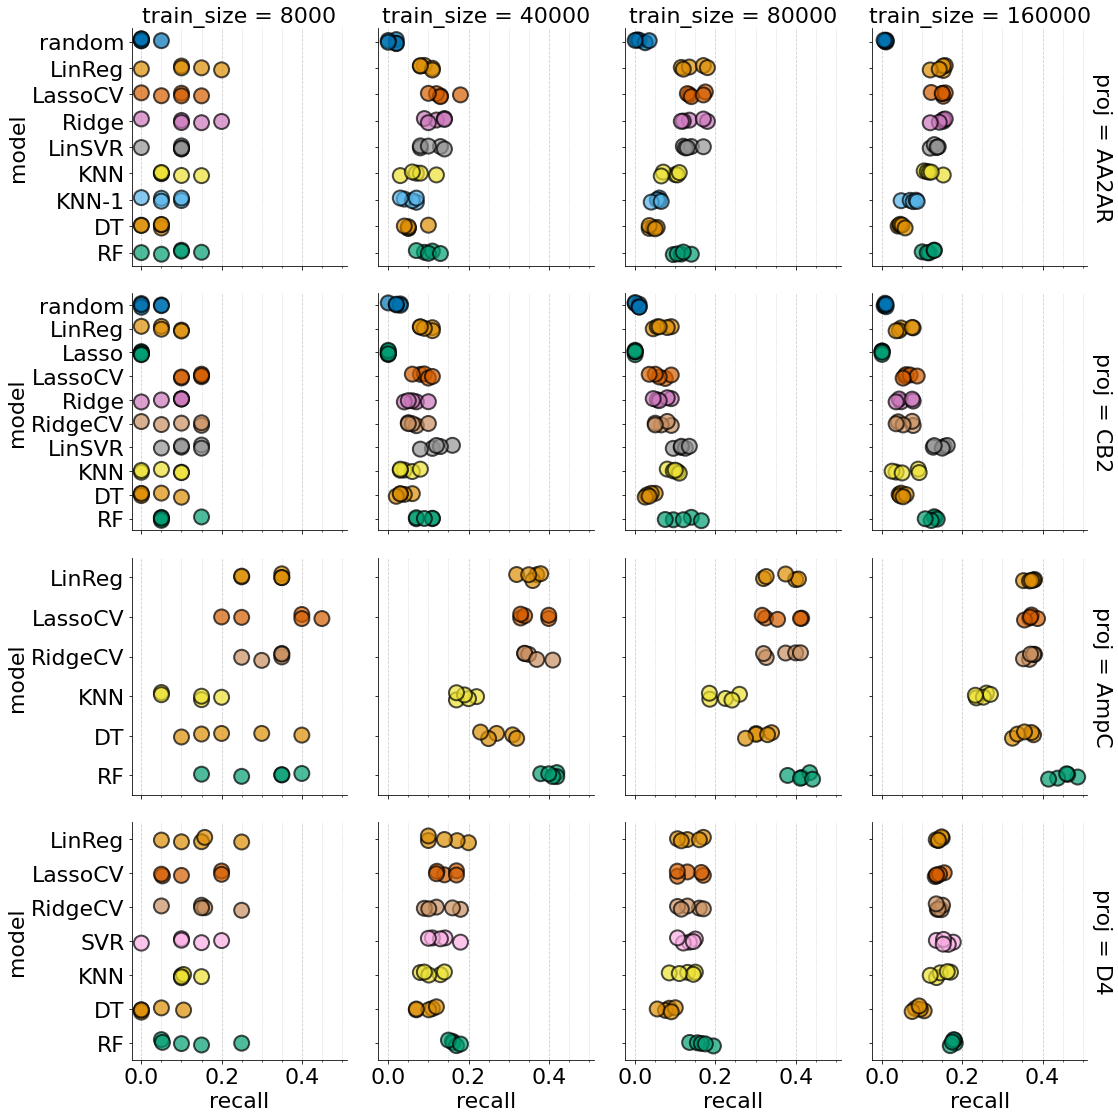

In [26]:
grid = sns.FacetGrid(
    data=df_p,
    col="train_size",
    row="proj",
    margin_titles=True,
    sharex=True,
    sharey="row",
    height=4,
    aspect=1.0,
    # row_order=row_order,
)

for ax in grid.axes.flat:
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(1))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))
    ax.grid(which="major", color="#CCCCCC", linestyle="--")
    ax.grid(which="minor", color="#CCCCCC", linestyle=":")

# ----------------------
interesting_regressors = [rename.get(val) for val in interesting_regressors]
colors = sns.color_palette("colorblind", n_colors=len(interesting_regressors))
palette = {tag: color for tag, color in zip(interesting_regressors, colors)}
custom_order = {
    k: [model for model in interesting_regressors
        if
        model in df_p.query(f'proj=="{k}"').model.unique()]
    for k in row_order
}

kwa = {
    "x": "recall",
    "y": "model",
    "edgecolor": "k",
    "linewidth": 2,
    "palette": palette,
    "s": 15,
    "alpha": 0.7,
    "order": custom_order,
}


grid.map_dataframe(
    ordered_stripplot,
    **kwa,
)
# grid.map_dataframe(
#    sns.stripplot,
#    **kwa,
# )

fout = "../figures/figure_3_single-shot-performance.png"
print(f"Saved figue to {fout=}")
plt.savefig(fout)
